<a href="https://colab.research.google.com/github/dankrelium/MVP_analise_de_dados/blob/main/MVP_An%C3%A1lise_de_dados_USD_x_BRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importações de bibliotecas



In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, YearLocator
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')


#Introdução





##Prever a variação da taxa de câmbio do dólar pode ser uma tarefa complexa e desafiadora, pois depende de vários fatores como indicadores macroeconômicos, eventos políticos e sentimentos de mercado. 
##A intenção deste notebook é analisar os indicadores de juros, crescimento econômico, inflação e risco como elementos determinantes desta variação, afim de criar um modelo de aprendizado supervisionado capaz de prever a oscilações do câmbio a partir da variação destes indicadores.
## A correlação entre cada um destes indicadores e o câmbio:
###1 - Inflação: considerando que esta representa a desvalorização de uma moeda, o valor de troca (câmbio) entre duas moedas será influenciado pela desvalorização de ambas as moedas.
###2 - Juros: considerando que as taxas básicas de juros representam uma referência do prêmio pago aos credores, variações nessas taxas alteram a atratividade dos ativos de uma economia, e influenciam  os fluxos de investimento, que tem impacto no câmbio.
###3 - Crescimento econômico - Em geral, quando a economia de um país está crescendo, há maior demanda por bens e serviços, o que pode levar a um aumento da demanda por sua moeda, que valoriza. (O inverso também se aplica)
###4 - Risco da dívida - A classificação de risco (rating) de um país afeta o câmbio devido ao conceito de aversão ao risco ([+](https://pt.wikipedia.org/wiki/Avers%C3%A3o_ao_risco)).





#Datasets

### **Utilizaremos os seguintes datasets para compor nosso dataset final:**

###**1 - Cotação Dólar x Real** (target) (Fonte: [Banco Central do Brasil](https://www.bcb.gov.br/))
- Intervalo - 03/01/2000 a 08/06/2021

###**2 - Inflação do Real** (Fonte: [IBGE](https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9256-indice-nacional-de-precos-ao-consumidor-amplo.html))
- Intervalo - 01/1980 a 05/2021

###**3 - Inflação do Dólar** (Fonte: [Federal Reserve](https://fred.stlouisfed.org/series/CPIAUCSL))
- Intervalo - 01/01/2000 a 01/01/2021

###**4 - Taxa Básica de Juros Brasileira** (Fonte: [Banco Central do Brasil](https://www.bcb.gov.br/))
- Intervalo - 01/01/2000 a 08/06/2021

###**5 - Taxa Básica de Juros Estadunidense** (Fonte: [Federal reserve](https://fred.stlouisfed.org/series/INTDSRUSM193N))
- Intervalo - 01/01/1950 a 01/05/2021

###**6 - Variação do PIB Brasileiro** (Fonte: [IBGE](https://www.ibge.gov.br/estatisticas/economicas/industria/9300-contas-nacionais-trimestrais.html?=&t=series-historicas))
- Intervalo - 1º trimestre 1996 a 4º trimestre 2021
- OBS: Valores referentes ao acumulado em 4 trimestres

###**7 - Variação do PIB Estadunidense** (Fonte: [Bureau of Economic Analysis](https://apps.bea.gov/iTable/?reqid=19&step=2&isuri=1&categories=survey#eyJhcHBpZCI6MTksInN0ZXBzIjpbMSwyLDMsM10sImRhdGEiOltbImNhdGVnb3JpZXMiLCJTdXJ2ZXkiXSxbIk5JUEFfVGFibGVfTGlzdCIsIjMxMCJdLFsiRmlyc3RfWWVhciIsIjIwMDAiXSxbIkxhc3RfWWVhciIsIjIwMjMiXSxbIlNjYWxlIiwiMCJdLFsiU2VyaWVzIiwiUSJdXX0=))
- Intervalo - 01/01/1947 a 01/10/2021
- OBS: Valores referentes ao acumulado em 4 trimestres

###**8 - Avaliação do grau de risco da dívida nacional** (Fonte: [Tesouro Nacional](https://sisweb.tesouro.gov.br/apex/f?p=2810:2:0:))
- Intervalo - 18/11/1986 a 20/12/2022

#Análise dos dados

### Como cada série possui um intervalo diferente, extrairemos o período entre jan/2010 a dez/2019 pelos motivos:
###1 - Dados recentes serão mais relevantes para a construção do modelo preditivo de apredizado supervisionado.
###2 - Com este intervalo excluímos o impacto das crises imobiliária de 2008 e o covid19 na cotação.
###3 - Todos os datasets possuem dados no período.

In [ ]:
# A seguinte função extrairá de um dataframe o período desejado:
data_inicial, data_final = '2010-01-01', '2020-01-01'
def selecionar_intervalo(self):
  self=self.loc[(self.index>=data_inicial)&(self.index<=data_final)]
  return self

###1 - Cotação Dólar x Real (target)

In [ ]:
# Carregando dataframe de Cotação Dólar x Real (target)
cotacao_dolar = pd.read_csv(r'https://raw.githubusercontent.com/dankrelium/publics_datasets/main/dolar_diaria.csv',
                            names=['Data', 'Cotacao_BRLxUSD'], # Renomeia as colunas
                            header=0, # Remove nome antigo das colunas
                            sep=';' # Define o elemento que separa as colunas
                            )

In [ ]:
cotacao_dolar

,Data,Cotacao_BRLxUSD
0,03/01/2000,1.8011
1,04/01/2000,1.8337
2,05/01/2000,1.8544
3,06/01/2000,1.8461
4,07/01/2000,1.8281
...,...,...
5378,02/06/2021,5.1147
5379,04/06/2021,5.0666
5380,07/06/2021,5.0498
5381,08/06/2021,5.0489


Como podemos observar acima, no dataset só constam valores referentes a dias úteis. Quando for preciso atribuir um valor para uma data de final de semana ou feriado, usaremos o valor do último dia útil.

In [ ]:
cotacao_dolar.drop(cotacao_dolar.tail(1).index,inplace=True) #Remove o rodapé
cotacao_dolar['Data'] =  pd.to_datetime(cotacao_dolar['Data'], format='%d/%m/%Y') # Converte a coluna 'Data' como objeto 'datetime'
cotacao_dolar['Cotacao_BRLxUSD'] = cotacao_dolar['Cotacao_BRLxUSD'].astype(float) # Converte a coluna 'Cotacao_BRLxUSD' como tipo float 
cotacao_dolar.set_index('Data', inplace=True) # Transforma a coluna 'Data' em index

In [ ]:
print("Valores Nulos:", cotacao_dolar.isnull().sum())

Valores Nulos: Cotacao_BRLxUSD    0
dtype: int64


###2 - Inflação do Real

In [ ]:
# Carregando dataframe de inflação do real
inflacao_real = pd.read_csv(r'https://raw.githubusercontent.com/dankrelium/publics_datasets/main/ipca_mensal.csv',
                            names=['Data', 'Inflacao_BR_mensal_perc'], # Renomeia as colunas
                            header=0, # Remove nome antigo das colunas
                            sep=';' # Define o elemento que separa as colunas
                            )

In [ ]:
inflacao_real

,Data,Inflacao_BR_mensal_perc
0,01/1980,6.62
1,02/1980,4.62
2,03/1980,6.04
3,04/1980,5.29
4,05/1980,5.70
...,...,...
493,02/2021,0.86
494,03/2021,0.93
495,04/2021,0.31
496,05/2021,0.83


In [ ]:
inflacao_real.drop(inflacao_real.tail(1).index,inplace=True) #Remove o rodapé
inflacao_real['Data'] =  pd.to_datetime(inflacao_real['Data'], format='%m/%Y') # Converte a coluna 'Data' como objeto 'datetime'
inflacao_real['Inflacao_BR_mensal_perc'] = inflacao_real['Inflacao_BR_mensal_perc'].astype(float) # Converte a coluna 'Inflacao_BR_mensal_%' como tipo float
inflacao_real.set_index('Data', inplace=True) # Transforma a coluna 'Data' em index

In [ ]:
print("Valores Nulos:")
print(inflacao_real.isnull().sum())

Valores Nulos:
Inflacao_BR_mensal_perc    0
dtype: int64


###3 - Inflação do Dólar

In [ ]:
# Carregando dataframe de inflação do dolar
inflacao_dolar = pd.read_csv(r'https://raw.githubusercontent.com/dankrelium/publics_datasets/main/inflacao_us_mensal.csv',
                            names=['Data', 'Inflacao_US_mensal_perc'], # Renomeia as colunas
                            header=0, # Remove nome antigo das colunas
                            )

In [ ]:
inflacao_dolar

,Data,Inflacao_US_mensal_perc
0,1947-02-01,0.65177
1,1947-03-01,1.75763
2,1947-04-01,0.00000
3,1947-05-01,-0.22727
4,1947-06-01,0.59226
...,...,...
908,2022-10-01,0.48830
909,2022-11-01,0.20504
910,2022-12-01,0.13128
911,2023-01-01,0.51707


In [ ]:
inflacao_dolar['Data'] =  pd.to_datetime(inflacao_dolar['Data'], format='%Y-%m-%d') # Converte a coluna 'Data' como objeto 'datetime'
inflacao_dolar['Inflacao_US_mensal_perc'] = inflacao_dolar['Inflacao_US_mensal_perc'].astype(float) # Converte a coluna 'Inflacao_BR_mensal_%' como tipo float
inflacao_dolar.set_index('Data', inplace=True) # Transforma a coluna 'Data' em index

In [ ]:
print("Valores Nulos:", inflacao_dolar.isnull().sum())

Valores Nulos: Inflacao_US_mensal_perc    0
dtype: int64


###4 - Taxa Básica de Juros Brasileira

In [ ]:
# Carregando dataframe da Selic
selic = pd.read_csv(r'https://raw.githubusercontent.com/dankrelium/publics_datasets/main/selic_diaria.csv',
                            names=['Data', 'Selic'], # Renomeia as colunas
                            header=0, # Remove nome antigo das colunas
                            sep=';' # Define o elemento que separa as colunas
                            )

In [ ]:
selic

,Data,Selic
0,01/01/2000,"19,00"
1,02/01/2000,"19,00"
2,03/01/2000,"19,00"
3,04/01/2000,"19,00"
4,05/01/2000,"19,00"
...,...,...
7826,05/06/2021,"3,50"
7827,06/06/2021,"3,50"
7828,07/06/2021,"3,50"
7829,08/06/2021,"3,50"


In [ ]:
selic.drop(selic.tail(1).index,inplace=True) #Remove o rodapé
selic['Data'] =  pd.to_datetime(selic['Data'], format='%d/%m/%Y') # Converte a coluna 'Data' como objeto 'datetime'
selic['Selic'] = [x.replace(',', '.') for x in selic['Selic']] # Substitui todas ',' por '.' na coluna "Selic" 
selic['Selic'] = selic['Selic'].astype(float) # Converte a coluna 'Selic' como tipo float 
selic.set_index('Data', inplace=True) # Transforma a coluna 'Data' em index

In [ ]:
print("Valores Nulos:", selic.isnull().sum())

Valores Nulos: Selic    0
dtype: int64


### 5 - Taxa Básica de Juros Americana (FFR)

In [ ]:
# Carregando dataframe da FFR
ffr = pd.read_csv(r'https://raw.githubusercontent.com/dankrelium/publics_datasets/main/juros_FED_us.csv',
                            names=['Data', 'FFR'], # Renomeia as colunas
                            header=0, # Remove nome antigo das colunas
                            )

In [ ]:
ffr

,Data,FFR
0,1950-01-01,1.50
1,1950-02-01,1.50
2,1950-03-01,1.50
3,1950-04-01,1.50
4,1950-05-01,1.50
...,...,...
852,2021-01-01,0.25
853,2021-02-01,0.25
854,2021-03-01,0.25
855,2021-04-01,0.25


In [ ]:
ffr['Data'] =  pd.to_datetime(ffr['Data'], format='%Y-%m-%d') # Converte a coluna 'Data' como objeto 'datetime'
ffr['FFR'] = ffr['FFR'].astype(float) # Converte a coluna 'ffr' como tipo float 
ffr.set_index('Data', inplace=True) # Transforma a coluna 'Data' em index

In [ ]:
print("Valores Nulos:", ffr.isnull().sum())

Valores Nulos: FFR    0
dtype: int64


### 6 - Variação do PIB Brasileiro

In [ ]:
pib_br_tri = pd.read_csv(r'https://raw.githubusercontent.com/dankrelium/publics_datasets/main/PIB_BR.csv', 
                                   skiprows=1, # remove cabeçalho
                                   sep=';', # Define o elemento que separa as colunas
                        )

pib_br_tri = pib_br_tri.iloc[:-1] # remove o rodapé
pib_br_tri

,,1º trimestre 1996,2º trimestre 1996,3º trimestre 1996,4º trimestre 1996,1º trimestre 1997,2º trimestre 1997,3º trimestre 1997,4º trimestre 1997,1º trimestre 1998,...,3º trimestre 2020,4º trimestre 2020,1º trimestre 2021,2º trimestre 2021,3º trimestre 2021,4º trimestre 2021,1º trimestre 2022,2º trimestre 2022,3º trimestre 2022,4º trimestre 2022
0,Brasil,2.5,2.1,2.3,2.2,3.2,4.0,3.0,3.4,2.8,...,-2.8,-3.3,-3.0,2.4,4.3,5.0,5.2,3.2,3.0,2.9


In [ ]:
#Pré-processamento para visualizar gráfico

pib_br_tri = pib_br_tri.T # Reflete o DataFrame sobre sua diagonal principal, escrevendo linhas em colunas e vice-versa.

pib_br_tri.index = pib_br_tri.index.str.replace('1º trimestre ', '01-01-', regex=True) # As próximas 4 linhas tem a função de preparar a coluna para converter em datetime.
pib_br_tri.index = pib_br_tri.index.str.replace('2º trimestre ', '01-04-', regex=True) # O método regex especifica que a substituição da string deve ser feita em todas as ocorrências desta no dataframe.  
pib_br_tri.index = pib_br_tri.index.str.replace('3º trimestre ', '01-07-', regex=True) 
pib_br_tri.index = pib_br_tri.index.str.replace('4º trimestre ', '01-10-', regex=True)

pib_br_tri = pib_br_tri.rename(columns={pib_br_tri.columns[0]: 'PIB_BR_TRI'})
pib_br_tri = pib_br_tri.drop(pib_br_tri.index[0])

pib_br_tri.index =  pd.to_datetime(pib_br_tri.index, format='%d-%m-%Y') # Converte a coluna 'Data' como objeto 'datetime'
pib_br_tri['PIB_BR_TRI'] = pib_br_tri['PIB_BR_TRI'].astype(float) # Converte a coluna 'PIB_BR_TRI' como tipo float 
pib_br_tri.index.name = 'Data' #Dá nome ao index

In [ ]:
pib_br_tri

,PIB_BR_TRI
Data,
1996-01-01,2.5
1996-04-01,2.1
1996-07-01,2.3
1996-10-01,2.2
1997-01-01,3.2
...,...
2021-10-01,5.0
2022-01-01,5.2
2022-04-01,3.2


Da forma como fizemos, o valor do crescimento econômico de um trimestre está sendo atribuído ao primeiro dia deste, quando seria mais adequado ser atribuído ao final. Para corrigir isto, usaremos o método "shift()" a seguir.

In [ ]:
pib_br_tri['PIB_BR_TRI'] = pib_br_tri['PIB_BR_TRI'].shift(1)

In [ ]:
print("Valores Nulos:", pib_br_tri.isnull().sum())

Valores Nulos: PIB_BR_TRI    1
dtype: int64


O valor Nulo = 1 ocorreu pelo uso do método shift que deixou a primeira linha sem valor atribuído, mas como a data do nulo está fora do intervalo de trabalho, será ignorado.

###7 - Variação do PIB Estadunidense

In [ ]:
# Carregando dataframe de crecimento americano
pib_us_tri = pd.read_csv(r'https://raw.githubusercontent.com/dankrelium/publics_datasets/main/GDP_US.csv',
                            sep = ",",
                            skiprows=3,
                            nrows=2
                            )

In [ ]:
pib_us_tri

,Line,Unnamed: 1,2000,2000.1,2000.2,2000.3,2001,2001.1,2001.2,2001.3,...,2020.3,2021,2021.1,2021.2,2021.3,2022,2022.1,2022.2,2022.3,2023
0,Line,NaN,Q1,Q2,Q3,Q4,Q1,Q2,Q3,Q4,...,Q4,Q1,Q2,Q3,Q4,Q1,Q2,Q3,Q4,Q1
1,1,Gross domestic product (GDP),4.2,5.2,4.0,2.9,2.2,1.0,0.5,0.2,...,-1.5,1.2,12.5,5.0,5.7,3.7,1.8,1.9,0.9,1.6


In [ ]:
# Arruma o dataframe "pib_us_tri", criando uma coluna com as datas do início de cada trimestre e atribuindo o valor do respectivo trimestre à data
pib_us_tri = pd.DataFrame({'PIB_US_TRI': pib_us_tri.iloc[1,2:].values}, index=pd.date_range(start='01/01/2000', end='01/01/2023', freq='QS'))
pib_us_tri['PIB_US_TRI'] = pib_us_tri['PIB_US_TRI'].astype(float)  # Converte a coluna 'pib_us_tri' como tipo float 
pib_us_tri.index.name = 'Data'  # Dá nome ao index

In [ ]:
pib_us_tri

,PIB_US_TRI
Data,
2000-01-01,4.2
2000-04-01,5.2
2000-07-01,4.0
2000-10-01,2.9
2001-01-01,2.2
...,...
2022-01-01,3.7
2022-04-01,1.8
2022-07-01,1.9


In [ ]:
print("Valores Nulos:", pib_us_tri.isnull().sum())

Valores Nulos: PIB_US_TRI    0
dtype: int64


###8 - Histórico da classificação de risco (variável categórica ordinal)

In [ ]:
# Carregando dataframe
classificacao_risco = pd.read_csv(r'https://raw.githubusercontent.com/dankrelium/MVP_analise_de_dados/main/historico_da_classificacao_para_a_divida_de_longo_prazo.csv',
                            names=['ultima_Alteracao', 'Agencia', 'Moeda_Estrangeira', 'Moeda_Local', 'acao'], # Renomeia as colunas
                            header=0, # Remove nome antigo das colunas
                            sep=';',
                            encoding='ISO-8859-1'
                            )

In [ ]:
classificacao_risco.head()

,ultima_Alteracao,Agencia,Moeda_Estrangeira,Moeda_Local,acao
0,20-DEZ-22,Fitch,BB-,BB-,Manutenção da nota e manutenção da perspectiva...
1,14-JUL-22,Fitch,BB-,BB-,Manutenção da nota e revisão da perspectiva pa...
2,14-JUN-22,Standard & Poor's,BB-,BB-,Manutenção da nota e manutenção da perspectiva...
3,12-ABR-22,Moody's,Ba2,Ba2,Manutenção da nota e manutenção da perspectiva...
4,14-DEZ-21,Fitch,BB-,BB-,Manutenção da nota e manutenção da perspectiva...


**Descrição colunas:**

**ultima_Alteracao** - data correspondente a última alteração do grau de risco

**Agencia** - Agencia que realizou a alteração do grau de risco

**Coluna Moeda_Estrangeira** - Considera a capacidade de pagamento de dívidas tanto em moeda estrangeira quanto local.

**Coluna Moeda_Local** - Diz respeito à capacidade de pagamento de dívidas apenas com a moeda local

**acao** - descrição da alteração do grau de risco naquela data.

Por tratar a capacidade de pagamento de forma mais abrangente, utilizaremos apenas a coluna "Moeda_Estrangeira".

In [ ]:
classificacao_risco = classificacao_risco.drop('Moeda_Local', axis=1) # Exclui coluna "Moeda_Local"
classificacao_risco = classificacao_risco.drop('acao', axis=1) # Exclui coluna "acao" 

# Altera strings da coluna "ultima_Alteracao" para posteriormente transformar em datetime
substituicoes = {'JAN': '01', 'FEV': '02', 'MAR': '03', 'ABR': '04', 'MAI': '05', 'JUN': '06', 'JUL': '07', 'AGO': '08', 'SET': '09', 'OUT': '10', 'NOV': '11', 'DEZ': '12'}

classificacao_risco['ultima_Alteracao'] = pd.to_datetime(classificacao_risco['ultima_Alteracao'].replace(substituicoes, regex=True), format='%d-%m-%y')  # Transforma em datetime
classificacao_risco.set_index('ultima_Alteracao', inplace=True)  # Transforma a coluna 'ultima_Alteracao' em index
classificacao_risco = classificacao_risco.iloc[::-1]  # Padroniza o dataset, invertendo a ordem das linhas para datas mais antigas ficarem nos primeiros índices.

In [ ]:
# Lista os valores únicos encontrados em cada coluna para verificar se há missings ou valores irreais 
for coluna in classificacao_risco:
    valores_encontrados = classificacao_risco[coluna].unique()
    print(f"Valores encontrados na coluna {coluna}: {valores_encontrados}")

Valores encontrados na coluna Agencia: ["Moody's" 'Fitch' "Standard & Poor's" 'R&I' 'JCR' 'DBRS']
Valores encontrados na coluna Moeda_Estrangeira: ['Ba1' 'B2' 'B1' 'B+' 'BB-' 'B' '-' 'Ba3' 'BB' 'Ba2' 'BB+' 'BBB-' 'Baa3'
 'BBB' 'Baa2' 'BB (low)']


In [ ]:
# Deleta linha que possui valor irreal '-'
classificacao_risco = classificacao_risco.drop(classificacao_risco[classificacao_risco['Moeda_Estrangeira'] == "-"].index)

In [ ]:
classificacao_risco.head()

,Agencia,Moeda_Estrangeira
ultima_Alteracao,,
1986-11-18,Moody's,Ba1
1989-03-31,Moody's,B2
1994-10-05,Moody's,B2
1994-11-30,Moody's,B1
1994-12-01,Fitch,B+


Para podermos analisar as variações de risco de cada agência separadamente, desmembraremos a coluna 'Agencia' em uma coluna para cada agência:

In [ ]:
#Cria uma coluna para cada valor da coluna "Agencia", atribuindo seus respectivos valores
for agencia in classificacao_risco["Agencia"].unique(): 
  classificacao_risco[agencia] = classificacao_risco["Moeda_Estrangeira"].loc[classificacao_risco['Agencia'] == agencia]

# Elimina coluna 'Agencia' e 'Moeda_Estrangeira'
classificacao_risco = classificacao_risco.drop(columns=['Agencia', 'Moeda_Estrangeira'], axis=1)

# Como as agências R&I, DBRS e JCR possuem menor relevância e seus dados não preenchem o intervalo estudado por completo, serão descartadas:
classificacao_risco = classificacao_risco.drop(['R&I', 'DBRS', 'JCR'], axis=1)

# Adiciona uma linha ao dataframe com a data inicial do intervalo que escolhemos e valores das colunas nulos
# Essa linha será importante posteriormente para plotarmos esses dados no intervalo completo
classificacao_risco = classificacao_risco.append(pd.DataFrame(index=pd.to_datetime([data_inicial]))).sort_index()

# Nomeia o label do index
classificacao_risco.index.name = 'Data' 

Considerando que as avaliações de risco permanecem constantes até que sejam alteradas, utilizaremos o método 'ffill' (forward fill) para substituir os valores 'Nan' de cada coluna pelo último valor definido na mesma:

In [ ]:
classificacao_risco = classificacao_risco.apply(lambda x: x.fillna(method='ffill')) 

### Juntando os 8 datasets em 1.

Criaremos um dataframe_geral para juntar os datasets em um só.

In [ ]:
dataframe_geral = cotacao_dolar.merge(inflacao_real, on='Data', how='outer'
                                      ).merge(inflacao_dolar, on='Data', how='outer'
                                      ).merge(selic, on='Data', how='outer'
                                      ).merge(ffr, on='Data', how='outer'
                                      ).merge(pib_br_tri, on='Data', how='outer'
                                      ).merge(pib_us_tri, on='Data', how='outer'
                                      ).merge(classificacao_risco, on='Data', how='outer')  
dataframe_geral = dataframe_geral.sort_index()  # Certifica que o index está em ordem cronológica

In [ ]:
selecionar_intervalo(dataframe_geral).head()

,Cotacao_BRLxUSD,Inflacao_BR_mensal_perc,Inflacao_US_mensal_perc,Selic,FFR,PIB_BR_TRI,PIB_US_TRI,Moody's,Fitch,Standard & Poor's
Data,,,,,,,,,,
2010-01-01,NaN,0.75,0.06487,8.75,0.5,-0.1,1.8,Baa3,BBB-,BBB-
2010-01-02,NaN,NaN,NaN,8.75,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,8.75,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1.7240,NaN,NaN,8.75,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,1.7227,NaN,NaN,8.75,NaN,NaN,NaN,NaN,NaN,NaN


No dataframe_geral, a ocorrência do nulos é consequência das diferentes frequências (diária, mensal, trimestral) de cada dado.

In [ ]:
selecionar_intervalo(dataframe_geral).describe()

,Cotacao_BRLxUSD,Inflacao_BR_mensal_perc,Inflacao_US_mensal_perc,Selic,FFR,PIB_BR_TRI,PIB_US_TRI
count,2512.000000,121.000000,121.000000,3653.000000,121.000000,41.000000,41.000000
mean,2.751282,0.471983,0.145306,9.995552,1.243802,1.421951,2.217073
std,0.839846,0.315477,0.190754,2.734504,0.757918,3.005038,0.681873
min,1.534500,-0.230000,-0.637030,4.500000,0.500000,-4.500000,0.800000
25%,1.987025,0.250000,0.028880,7.250000,0.750000,-0.100000,1.700000
50%,2.624500,0.450000,0.178730,10.500000,0.750000,1.800000,2.200000
75%,3.481100,0.640000,0.262320,12.000000,1.750000,3.000000,2.600000
max,4.260200,1.320000,0.580950,14.250000,3.000000,7.500000,3.800000


**Verificando graficamente se há presença de outliers:**

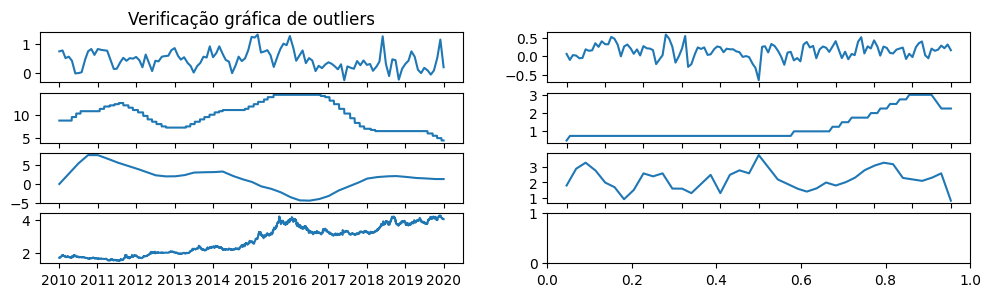

In [ ]:
fig, axs = plt.subplots(4,2,figsize=(12, 3))
axs[0,0].set_title('Verificação gráfica de outliers')
# Curvas do dataset
axs[0,0].plot(selecionar_intervalo(dataframe_geral["Inflacao_BR_mensal_perc"]).index, selecionar_intervalo(dataframe_geral["Inflacao_BR_mensal_perc"]).interpolate())
axs[0,1].plot(selecionar_intervalo(dataframe_geral["Inflacao_US_mensal_perc"]).index, selecionar_intervalo(dataframe_geral["Inflacao_US_mensal_perc"]).interpolate())
axs[1,0].plot(selecionar_intervalo(dataframe_geral["Selic"]).index, selecionar_intervalo(dataframe_geral["Selic"]).interpolate())
axs[1,1].plot(selecionar_intervalo(dataframe_geral["FFR"]).index, selecionar_intervalo(dataframe_geral["FFR"]).interpolate())
axs[2,0].plot(selecionar_intervalo(dataframe_geral["PIB_BR_TRI"]).index, selecionar_intervalo(dataframe_geral["PIB_BR_TRI"]).interpolate())
axs[2,1].plot(selecionar_intervalo(dataframe_geral["PIB_US_TRI"]).index, selecionar_intervalo(dataframe_geral["PIB_US_TRI"]).interpolate())
axs[3,0].plot(selecionar_intervalo(dataframe_geral["Cotacao_BRLxUSD"]).index, selecionar_intervalo(dataframe_geral["Cotacao_BRLxUSD"]).interpolate())

plt.show()

Não há outliers.

#Pré-processamento de dados

##Para tornar mais evidente os efeitos de cada indicador no câmbio nominal, vamos realizar algumas fusões nos dados, onde:
###1 - As inflações serão unidas em um indicador chamado câmbio inicial ajustado a inflação (CN). 
###2 - Os juros serão convertidos no indicador diferencial de juros real.
###3 - Os crescimentos das economias serão convertidos no indicador diferencial de crescimento econômico.
###4 - As avaliações de risco serão transformadas em média de risco.

### **Todos os dados resultantes terão correlação positiva com o câmbio.**

##Câmbio inicial ajustado à inflação

A taxas de câmbio nominais compensadas pelas diferenças de inflação entre os países será dada pela seguinte fórmula:

$CN_{t} = CN_{t-1}*(1+Ii_{t})/(1+Ie_{t})$

onde:

$CN$ = câmbio nominal ($CN_{0}$ vai ser a cotação observada na data_inicial = 2010-01-01)

$Ii$ = inflação interna (R$)

$Ie$ = inflação externa ($)

In [ ]:
# Cria um dataframe novo com uma coluna para inflacao_real e outra para inflacao_dolar
cambio_inicial_ajust_inf = selecionar_intervalo(inflacao_real).merge(selecionar_intervalo(inflacao_dolar), on='Data', how='outer')

Verificando se os dataframes possuem datas diferentes:
(zero nulos implica que não):

In [ ]:
print("Valores Nulos:", cambio_inicial_ajust_inf.isnull().sum())

Valores Nulos: Inflacao_BR_mensal_perc    0
Inflacao_US_mensal_perc    0
dtype: int64


In [ ]:
cambio_inicial_ajust_inf['cambio_inicial_ajust_inf'] = ""  # Cria coluna em branco para receber valores da equação
fator_ac = selecionar_intervalo(cotacao_dolar).iloc[0,0]  # Seleciona a cotação na data 2010-01-01

# Aplica a fórmula CNt=CNt−1∗(1+Iit)/(1+Iet)
for x,y in cambio_inicial_ajust_inf.iterrows():  
    cambio_inicial_ajust_inf.loc[x,'cambio_inicial_ajust_inf'] = fator_ac*(1+cambio_inicial_ajust_inf.loc[x,'Inflacao_BR_mensal_perc']/100)/(1+cambio_inicial_ajust_inf.loc[x,'Inflacao_US_mensal_perc']/100)
    fator_ac = cambio_inicial_ajust_inf.loc[x,'cambio_inicial_ajust_inf']

cambio_inicial_ajust_inf["cambio_inicial_ajust_inf"]=cambio_inicial_ajust_inf["cambio_inicial_ajust_inf"].astype(float)  #Converte valores em float
cambio_inicial_ajust_inf = cambio_inicial_ajust_inf.drop(columns=['Inflacao_BR_mensal_perc', 'Inflacao_US_mensal_perc'], axis=1)  # Descarta colunas 

In [ ]:
print("Valores Nulos:", cambio_inicial_ajust_inf.isnull().sum())

Valores Nulos: cambio_inicial_ajust_inf    0
dtype: int64


##Diferencial de juros real

Vamos converter o juros de nominal(i) para real(r), isto é, descontando a inflação(j), de acordo com a fórmula: 

$(1+i)=(1+r)×(1+j)$.

Como o juros se refere ao prêmio após 12 meses, calcularemos a inflação acumulada em 12 meses para depois calcular os juros reais.


Após isso, calcularemos o diferencial de juros real (IRD - Interest Rate Differential) pela seguinte fórmula:

$IRD = r_{e} - r_{i}$


onde:

$DJ$ = diferencial de juros

$r_{e}$ = juros real externo

$r_{i}$ = juros real interno


In [ ]:
# Calcula a inflação acumulada nos últimos 12 meses da moeda Brasileira
inflacao_real_acumulada = pd.DataFrame({'inflacao_real_acumulado_12_meses':(1+inflacao_real['Inflacao_BR_mensal_perc']/100)*(1+inflacao_real['Inflacao_BR_mensal_perc']/100).shift(11, fill_value=1).rolling(window=11, min_periods=1).apply(lambda x: x.prod(), raw=True)})

# Calcula a inflação acumulada nos últimos 12 meses da moeda Americana
inflacao_dolar_acumulada = pd.DataFrame({'inflacao_dolar_acumulado_12_meses':(1+inflacao_dolar['Inflacao_US_mensal_perc']/100)*(1+inflacao_dolar['Inflacao_US_mensal_perc']/100).shift(11, fill_value=1).rolling(window=11, min_periods=1).apply(lambda x: x.prod(), raw=True)})

Se 

$IRD = r_{e} - r_{i}$ 

e 

$(1+i)=(1+r)×(1+j)$

Então:

$IRD = (1+i_{e})/(1+j_{e})-(1+i_{i})/(1+j_{i})$

In [ ]:
# Junta os dados em um único dataframe
ird = selecionar_intervalo(selic).join([selecionar_intervalo(inflacao_real_acumulada), selecionar_intervalo(ffr), selecionar_intervalo(inflacao_dolar_acumulada)])
ird.head()

,Selic,inflacao_real_acumulado_12_meses,FFR,inflacao_dolar_acumulado_12_meses
Data,,,,
2010-01-01,8.75,1.061869,0.5,0.997166
2010-01-02,8.75,NaN,NaN,NaN
2010-01-03,8.75,NaN,NaN,NaN
2010-01-04,8.75,NaN,NaN,NaN
2010-01-05,8.75,NaN,NaN,NaN


Como as taxas de juros são constantes até que os Bancos centrais as mudem, substituiremos os valores NaN da coluna "FFR" usando o método ffill.
Já as inflações consideraremos como um movimento de flutuação contínuo, então substituiremos os Nan interpolando entre os valores de trás e a frente.

In [ ]:
# Aplicando ffill
ird["FFR"] = ird["FFR"].fillna(method='ffill') 
# Aplicando interpolação
ird[['inflacao_real_acumulado_12_meses', 'inflacao_dolar_acumulado_12_meses']] = ird[['inflacao_real_acumulado_12_meses', 'inflacao_dolar_acumulado_12_meses']].interpolate()

In [ ]:
# Aplicando nos dados a fórmula IRD=(1+ie)/(1+je)−(1+ii)/(1+ji)
ird = pd.DataFrame({'diferencial_de_juros':(1+ird["FFR"])/(1+ird["inflacao_dolar_acumulado_12_meses"])-(1+ird["Selic"])/(1+ird["inflacao_real_acumulado_12_meses"])})

##Diferencial de crescimento econômico

Calcularemos o diferencial de crescimento econômico (DRG - Differential Rates of Growth) pela seguinte fórmula:

$DRG = ΔY_{e} - ΔY_{i}$

onde:

$DRG$ = diferencial de juros

$ΔY_{e}$ = taxa de crescimento externa

$ΔY_{i}$ = taxa de crescimento interno


In [ ]:
# Aplica a fórmula
drg = pd.DataFrame({'diferencial_cresc_economico':selecionar_intervalo(pib_us_tri["PIB_US_TRI"]) - selecionar_intervalo(pib_br_tri["PIB_BR_TRI"])})

In [ ]:
print("Valores Nulos:", drg.isnull().sum())

Valores Nulos: diferencial_cresc_economico    0
dtype: int64


## Média de risco

Para extrair a média de risco, transformaremos as variáveis categóricas ordinais em números de acordo com a equivalência do gráfico abaixo, onde:

**['AAA', 'Aaa'] = 0** 

**['AA+', 'Aa1'] = 1**  

... 

**['C', 'D'] = 20**

e então extrairemos a média das 3 notas. Quanto maior a média, maior o risco.

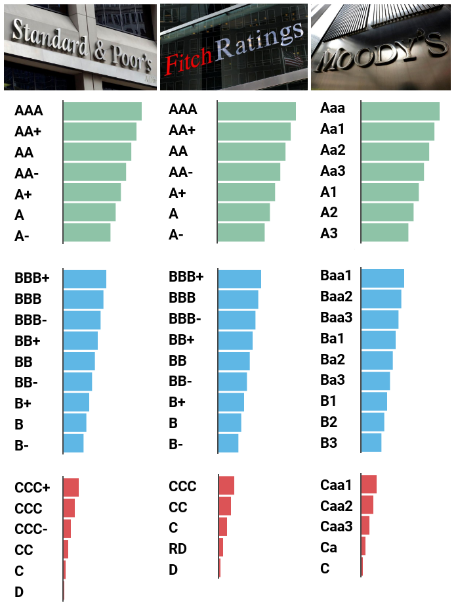

O gráfico acima foi retirado do [infomoney](https://www.infomoney.com.br/economia/o-que-falta-para-o-brasil-ter-o-rating-elevado-veja-o-que-dizem-as-agencias-de-risco/)

In [ ]:
# Cria uma cópia do dataframe 'classificacao_risco' chamada 'classificacao_risco_numerica'
classificacao_risco_numerica = classificacao_risco.loc[:, ["Fitch", "Standard & Poor's", "Moody's"]].copy()

In [ ]:
# Lista das avaliações possíveis, onde o index da avaliação corresponde ao valor númerico da mesma
lista = [['AAA', 'Aaa'],['AA+', 'Aa1'],['AA', 'Aa2'],['AA-', 'Aa3'],['A+', 'A1'],['A', 'A2'],['A-', 'A3'],['BBB+', 'Baa1'],['BBB', 'Baa2'],['BBB-', 'Baa3'],['BB+', 'Ba1'],['BB', 'Ba2'],['BB-', 'Ba3'],['B+', 'B1'],['B', 'B2'],['B-', 'B3']]

# Transforma as avaliações em texto para seu equivalente numérico
for x in lista:
  classificacao_risco_numerica.replace(x, float(lista.index(x)), inplace=True)

# Atribui a médias das 3 notas a uma nova coluna
classificacao_risco_numerica['media'] = classificacao_risco_numerica[['Fitch', "Standard & Poor's", "Moody's"]].apply(lambda x: x.mean(), axis=1)


In [ ]:
selecionar_intervalo(classificacao_risco_numerica).head()

,Fitch,Standard & Poor's,Moody's,media
Data,,,,
2010-01-01,9.0,9.0,9.0,9.000000
2010-06-30,9.0,9.0,9.0,9.000000
2011-04-04,8.0,9.0,9.0,8.666667
2011-08-25,8.0,9.0,9.0,8.666667
2011-11-17,8.0,8.0,9.0,8.333333


##Ajustes no dataframe_geral 

In [ ]:
# Adiciona novos dados ao dataframe_geral
dataframe_geral = dataframe_geral.merge(cambio_inicial_ajust_inf, on='Data', how='outer'
                                        ).merge(ird, on='Data', how='outer'
                                        ).merge(drg, on='Data', how='outer'
                                        ).merge(classificacao_risco_numerica["media"], on='Data', how='outer')  
dataframe_geral = dataframe_geral.sort_index()  # Certifica que o index está em ordem cronológica

In [ ]:
selecionar_intervalo(dataframe_geral[["Cotacao_BRLxUSD","cambio_inicial_ajust_inf","diferencial_de_juros","diferencial_cresc_economico","media"]]).head()

,Cotacao_BRLxUSD,cambio_inicial_ajust_inf,diferencial_de_juros,diferencial_cresc_economico,media
Data,,,,,
2010-01-01,NaN,1.735804,-3.977656,1.9,9.0
2010-01-02,NaN,NaN,-3.977847,NaN,NaN
2010-01-03,NaN,NaN,-3.978038,NaN,NaN
2010-01-04,1.7240,NaN,-3.978229,NaN,NaN
2010-01-05,1.7227,NaN,-3.978420,NaN,NaN


In [ ]:
print("Valores Nulos:")
print(selecionar_intervalo(dataframe_geral[["Cotacao_BRLxUSD","cambio_inicial_ajust_inf","diferencial_de_juros","diferencial_cresc_economico","media"]]).isnull().sum())

Valores Nulos:
Cotacao_BRLxUSD                1141
cambio_inicial_ajust_inf       3532
diferencial_de_juros              0
diferencial_cresc_economico    3612
media                          3607
dtype: int64


Regras de substituição de valores nulos:
- Cotacao_BRLxUSD: Finais de semana e feriados as cotações permanecem constantes ao último valor, usaremos ffill.
- cambio_inicial_ajust_inf: Por ser relativo a flutuação contínua das inflações, usaremos interpolate.
- diferencial_cresc_economico: Por ser relativo a flutuação contínua da atividade econômica, usaremos interpolate.
- media: é constante até que alguma agência mude o grau de risco, usaremos ffill.

In [ ]:
# Aplicando ffill
dataframe_geral[["Cotacao_BRLxUSD","media"]] = dataframe_geral[["Cotacao_BRLxUSD","media"]].fillna(method='ffill') 
# Aplicando interpolação
dataframe_geral[['cambio_inicial_ajust_inf', 'diferencial_cresc_economico']] = dataframe_geral[['cambio_inicial_ajust_inf', 'diferencial_cresc_economico']].interpolate()

In [ ]:
selecionar_intervalo(dataframe_geral[["Cotacao_BRLxUSD","cambio_inicial_ajust_inf","diferencial_de_juros","diferencial_cresc_economico","media"]]).describe()

,Cotacao_BRLxUSD,cambio_inicial_ajust_inf,diferencial_de_juros,diferencial_cresc_economico,media
count,3653.000000,3653.000000,3653.000000,3653.000000,3653.000000
mean,2.751762,2.174737,-4.223385,0.796441,9.594489
std,0.839565,0.279440,1.548086,2.961210,1.420864
min,1.534500,1.735804,-6.521533,-5.500000,8.000000
25%,1.984800,1.897235,-5.453127,-0.880000,8.333333
50%,2.652700,2.174180,-4.630805,0.604348,9.000000
75%,3.477200,2.457887,-3.140314,3.217391,11.000000
max,4.260200,2.555728,-1.078674,6.100000,11.666667


# Visualizações

##**Matriz de correlação:**

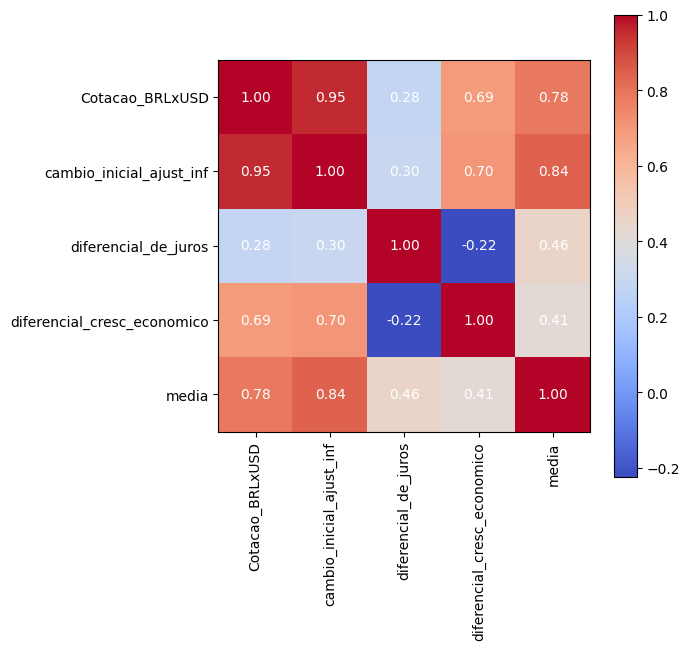

In [ ]:
# calcular a matriz de correlação
corr_matrix = selecionar_intervalo(dataframe_geral[["Cotacao_BRLxUSD","cambio_inicial_ajust_inf","diferencial_de_juros","diferencial_cresc_economico","media"]]).corr()


# plotar a matriz de correlação como um heatmap
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)

# adicionar os valores de correlação no quadrado
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, "{:.2f}".format(corr_matrix.iloc[i, j]), ha="center", va="center", color="w")

plt.show()

A matriz evidencia que existe notória correlação positiva entre a cotação e as demais variáveis, com exceção do diferencial de juros.

Abaixo veremos outra matriz, desta vez entre a cotação, o diferencial de juros e ambos os juros que compuseram o diferencial para entendermos melhor a baixa correlação:

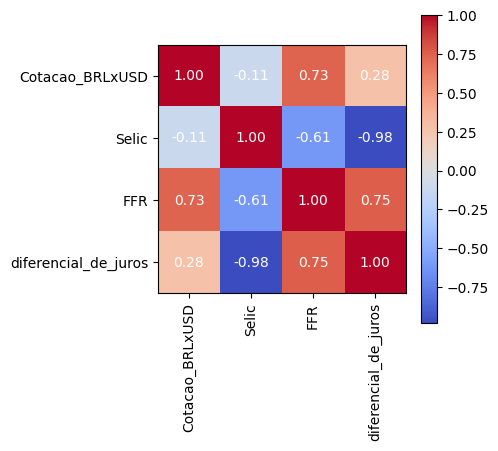

In [ ]:
# calcular a matriz de correlação
corr_matrix = selecionar_intervalo(dataframe_geral[["Cotacao_BRLxUSD", "Selic", "FFR","diferencial_de_juros"]]).corr()

# plotar a matriz de correlação como um heatmap
fig, ax = plt.subplots(figsize=(4, 4))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)

# adicionar os valores de correlação no quadrado
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, "{:.2f}".format(corr_matrix.iloc[i, j]), ha="center", va="center", color="w")

plt.show()

Podemos observar que a taxa de juros externa possui alta correlação com a cotação.

A correlação da taxa de juros interna é negativa como esperado, porém quase zero.

##**Visualização gráfica das séries temporais:**

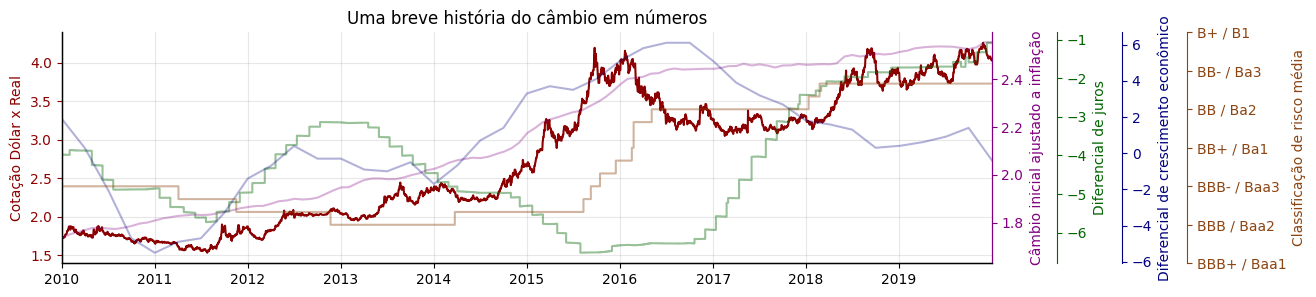

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 3))
#plt.figure()
ax1.set_title('Uma breve história do câmbio em números')
ax2, ax3, ax4, ax5 = ax1.twinx(), ax1.twinx(), ax1.twinx(), ax1.twinx() # Cria os eixos

# Curva de cotação e parâmetros
ax1.plot(selecionar_intervalo(dataframe_geral["Cotacao_BRLxUSD"]).index, selecionar_intervalo(dataframe_geral["Cotacao_BRLxUSD"]), 'darkred', label="")
ax1.spines['left'].set_color('darkred')
ax1.spines['top'].set_visible(False)
ax1.tick_params(colors='darkred', axis='y', labelsize=10)
ax1.set_ylabel('Cotação Dólar x Real', color='darkred')

# Curva de Câmbio ajustado a inflação e parâmetros
ax2.plot(selecionar_intervalo(dataframe_geral["cambio_inicial_ajust_inf"]).index, selecionar_intervalo(dataframe_geral["cambio_inicial_ajust_inf"]), 'purple', label="", alpha=.3)
ax2.spines['right'].set_color('purple')
ax2.spines['top'].set_visible(False)
ax2.tick_params(colors='purple')
ax2.set_ylabel('Câmbio inicial ajustado a inflação', color='purple')
ax2.set_ylim([1.63, None])

# Curva de Diferencial de juros e parâmetros
ax3.plot(selecionar_intervalo(dataframe_geral["diferencial_de_juros"]).index, selecionar_intervalo(dataframe_geral["diferencial_de_juros"]), 'darkgreen',  drawstyle='steps-post', label="", alpha=.4)
ax3.spines["right"].set_position(("axes", 1.07))
ax3.spines['right'].set_color('darkgreen')
ax3.spines['top'].set_visible(False)
ax3.tick_params(colors='darkgreen')
ax3.set_ylabel('Diferencial de juros', color='darkgreen')

# Curva de Diferencial de crescimento econômico e parâmetros
ax4.plot(selecionar_intervalo(dataframe_geral["diferencial_cresc_economico"]).index, selecionar_intervalo(dataframe_geral["diferencial_cresc_economico"]), 'navy', label="", alpha=.3)
ax4.spines["right"].set_position(("axes", 1.14))
ax4.spines['right'].set_color('navy')
ax4.spines['top'].set_visible(False)
ax4.tick_params(colors='navy')
ax4.set_ylabel('Diferencial de crescimento econômico', color='navy')

# Curva de Classificação de risco média e parâmetros
ax5.plot(selecionar_intervalo(dataframe_geral["media"]).index, selecionar_intervalo(dataframe_geral["media"]), 'saddlebrown',  drawstyle='steps-post', label="", alpha=.4)
ax5.spines["right"].set_position(("axes", 1.21))
ax5.spines['right'].set_color('saddlebrown')
ax5.spines['top'].set_visible(False)
ax5.tick_params(colors='saddlebrown')
ax5.set_ylabel('Classificação de risco média', color='saddlebrown')
ax5.set_yticks([7,8,9,10,11,12,13], labels=['BBB+ / Baa1','BBB / Baa2','BBB- / Baa3','BB+ / Ba1','BB / Ba2','BB- / Ba3', 'B+ / B1'])

ax1.xaxis.set_major_locator(YearLocator())  # Define os marcadores do eixo X
ax1.set_xlim(selecionar_intervalo(classificacao_risco_numerica).index[0], selecionar_intervalo(cotacao_dolar).index[-1]) # Encosta as curvas nos eixos Y
ax1.grid(alpha=0.3) # Atribui transparência ao grid

plt.show()

A ideia deste gráfico é podermos visualisar o comportamento de todos os elementos juntos ao longo do tempo.
Como há excesso de informações, algumas estratégias foram utilizadas para facilitar a leitura, como:
- O elemento principal (câmbio) é o único com uma cor escura. Os demais elementos estão em tons pastel, dessa forma o gráfico fica mais leve e se estabelece uma hierarquia entre eles .
- O único eixo a esquerda representa o elemento principal, reforçando sua hierarquia.
- A legenda de cada cor fica junto do seu eixo, para uma associação rápida e intuitiva entre váriavel e valor.
- Foram escolhidas cores com maior contraste entre si, para uma diferenciação mais rápida.


# Padronização

In [ ]:
# Cria novo dataframe apenas com os dados finais
dataframe_final = selecionar_intervalo(dataframe_geral[["Cotacao_BRLxUSD","cambio_inicial_ajust_inf","diferencial_de_juros","diferencial_cresc_economico","media"]])

In [ ]:
dataframe_final.head()

,Cotacao_BRLxUSD,cambio_inicial_ajust_inf,diferencial_de_juros,diferencial_cresc_economico,media
Data,,,,,
2010-01-01,1.7412,1.735804,-3.977656,1.900000,9.0
2010-01-02,1.7412,1.736294,-3.977847,1.882222,9.0
2010-01-03,1.7412,1.736785,-3.978038,1.864444,9.0
2010-01-04,1.7240,1.737276,-3.978229,1.846667,9.0
2010-01-05,1.7227,1.737766,-3.978420,1.828889,9.0


In [ ]:
# Padronizando as colunas do DataFrame
dataframe_final_padronizado = pd.DataFrame(StandardScaler().fit_transform(dataframe_final), columns=dataframe_final.columns)

In [ ]:
dataframe_final_padronizado.head()

,Cotacao_BRLxUSD,cambio_inicial_ajust_inf,diferencial_de_juros,diferencial_cresc_economico,media
0,-1.203838,-1.570973,0.158753,0.372723,-0.418457
1,-1.203838,-1.569217,0.158630,0.366718,-0.418457
2,-1.203838,-1.567462,0.158506,0.360714,-0.418457
3,-1.224327,-1.565706,0.158383,0.354709,-0.418457
4,-1.225876,-1.563951,0.158259,0.348705,-0.418457


# Normalização

In [ ]:
# Normalizando as colunas do DataFrame
dataframe_final_normalizado = pd.DataFrame(MinMaxScaler().fit_transform(dataframe_final), columns=dataframe_final.columns)

In [ ]:
dataframe_final_normalizado.head()

,Cotacao_BRLxUSD,cambio_inicial_ajust_inf,diferencial_de_juros,diferencial_cresc_economico,media
0,0.075834,0.000000,0.467379,0.637931,0.272727
1,0.075834,0.000598,0.467344,0.636398,0.272727
2,0.075834,0.001196,0.467309,0.634866,0.272727
3,0.069523,0.001795,0.467274,0.633333,0.272727
4,0.069046,0.002393,0.467239,0.631801,0.272727
